In [1]:
import pandas as pd
import numpy as np
import os 
import json
from haralyzer import HarParser, HarPage
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_text_content(edge):
    try:
        return edge['node']['comet_sections']['content']['story']['message']['text']
    except:
        try:
            print('----exception getting text-----------')
            print(edge['node']['comet_sections']['content']['story']['comet_sections']['context_layout']['story']['comet_sections']['title']['story']['title']['text'])
            print('-------------------------------------')
        except:
            try:
                print(edge['node']['comet_sections']['header']['story']['story_header']['title']['text'])
                print('-------------------------------------')
            except:
                try:
                    print('Returned shared post instead')
                    ## this returns a shared story
                    return edge['node']['comet_sections']['content']['story']['comet_sections']['attached_story']['story']['attached_story']['comet_sections']['attached_story_layout']['story']['message']['text']
                    print('-------------------------------------')
                except:
                    #print(edge['node']['comet_sections']['content']['story']['comet_sections']['attached_story']['story']['attached_story']['comet_sections']['attached_story_layout']['story'])
                    print('boopityboop')
                    #raise Exception('Here')
        return False

In [3]:
## helper functions

def get_directory_file_names(directory_location):
    return os.listdir(directory_location)
    
## in har data the response.content.text contains multipel json objects
def create_json_responses(entry):
    try:
        return [json.loads(entry) for entry in entry['response']['content']['text'].split('\r\n')]
    except:
        try:
            ## On this id we have broken json for e200
            if "2788301151475387v" in entry['response']['content']['text']:
                return [json.loads(entry) for entry in entry['response']['content']['text'].split('\r\n')[:14]]
            ## On this id we have broken json 
            if "906423103837537a" in entry['response']['content']['text']:
                return [json.loads(entry) for entry in entry['response']['content']['text'].split('\r\n')[:8]]
            else:
                ignore_types = ['image/jpeg', 'image/png', 'application/x-javascript', 'text/css', image/gif]
                if any(ignore_type in str(entry['response']['content']['mimeType']) for ignore_type in ignore_types):
                    return []
                print("bad exception")
                return []
        except:
            ignore_types = ['text/srt', "text/html", "text/css", "application/x-javascript", "application/json", "x-unknown", 
                           "image/jpeg", "image/png", "image/x-icon", "text/javascript", "image/x.fb.keyframes", "image/webp",
                           "video/mp4", 'video/webm', 'image/gif']
            if any(ignore_type in str(entry['response']['content']) for ignore_type in ignore_types):
                return []
            if 'bodySize' in entry['response']:
                if entry['response']['bodySize'] == -1:
                    return []

            #print(entry['response'])
            print("bad exception 2")
            return []
        

def get_date_content(edge):
    return datetime.fromtimestamp(edge['node']['comet_sections']['content']['story']['comet_sections']['context_layout']['story']['comet_sections']['metadata'][0]['story']['creation_time'])

def is_valid_structure(response):
    if "node" not in response['data']:
        return False
    if "timeline_list_feed_units" not in response['data']['node'] and "comet_sections" not in response['data']['node'] and "timeline_feed_units" not in response['data']['node']:
        return False
    return True

def is_comet_sections(response):
    if "timeline_list_feed_units" not in response['data']['node'] and "timeline_feed_units" not in response['data']['node']:
        if "comet_sections" in response['data']['node']: ## some posts dont have timeline_list_feed_units, but have comet_sections instead
            return True
    return False

def is_timeline_list_feed_untis(response):
    if "timeline_feed_units" in response['data']['node']:
        return False
    return True

def handle_timeline_list_feed_content(response):
    text_arr = []
    date_arr = []
    edges = response['data']['node']['timeline_list_feed_units']['edges']
    for edge in edges:
        if not is_valid_edge(edge):
            continue
        #print("---------------->", get_text_content(edge))
        text_arr.append(get_text_content(edge))
        date_arr.append(get_date_content(edge))
        
    return text_arr, date_arr

def handle_timeline_feed_content(response):
    text_arr = []
    date_arr = []
    edges = response['data']['node']['timeline_feed_units']['edges']
    for edge in edges:
        if not is_valid_edge(edge):
            continue
        #print("---------------->", get_text_content(edge))
        text_arr.append(get_text_content(edge))
        date_arr.append(get_date_content(edge))
        
    return text_arr, date_arr

def handle_comet_section_content(response):
    edge = response['data']
    return [get_text_content(edge)], [get_date_content(edge)]

## ['data']['node']['comet_sections']['content']['story']['message']['text']
def is_valid_edge(edge):
    if 'node' not in edge:
        return False
    
    if 'comet_sections' not in edge['node']:
        return False
    
    if 'content' not in edge['node']['comet_sections']:
        return False
    
    if 'story' not in edge['node']['comet_sections']['content']:
        return False
    
    if 'message' not in edge['node']['comet_sections']['content']['story']:
        return False
    if edge['node']['comet_sections']['content']['story']['message'] == None:
        return False
    
    if 'text' not in edge['node']['comet_sections']['content']['story']['message']:
        return False
    
    ## skip events
    if "EVENT_RSVP" in str(edge['node']['comet_sections']['content']['story']['message']):
        return False
        
    return True
    
    
    
def parse_har_file(har_data):
    text_arr = []
    date_arr = []
    
    for entry in har_data["entries"]:
        responses =  create_json_responses(entry)
        for response in responses:
            try:
                response_texts = []
                response_dates = []

                if not is_valid_structure(response):
                    continue

                if (is_comet_sections(response)):
                    ## skip events
                    if "EVENT_RSVP" in str(response['data']):
                        print("skipped here instead")
                        continue
                    
                    response_texts, response_dates = handle_comet_section_content(response)
                else:
                    if (is_timeline_list_feed_untis(response)):
                        response_texts, response_dates = handle_timeline_list_feed_content(response)
                    else:
                        response_texts, response_dates = handle_timeline_feed_content(response)

                text_arr = text_arr + response_texts
                date_arr = date_arr + response_dates
            except:
                continue

        
                
        
            
        
    return text_arr, date_arr

def get_file_data(filename):
    filename_split = filename.split("/")[1].split("_")
    nimi = " ".join(filename_split[1:]).split(".")[0]
    erakond = filename_split[0]
    print(filename_split)
    print("--------------------------------------")
    print(filename)
    with open(filename, 'r', encoding="utf8") as f:
        har_parser = HarParser(json.loads(f.read()))
        data = har_parser.har_data
        text_arr, date_arr = parse_har_file(data)
        person_arr = np.full(shape = len(text_arr), fill_value = nimi)
        erakond_arr = np.full(shape = len(text_arr), fill_value = erakond)
        return text_arr, date_arr, person_arr, erakond_arr

In [ ]:
directory_name = 'har_data_2'
directory_file_names = get_directory_file_names(directory_name)


final_text_arr = []
final_date_arr = []
final_person_arr = []
final_erakond_arr = []

for filename in directory_file_names:
    text_arr, date_arr, person_arr, erakond_arr = get_file_data(directory_name + "/" + filename)
    
    final_text_arr = final_text_arr + text_arr
    final_date_arr = final_date_arr + date_arr
    final_person_arr.extend(person_arr)
    final_erakond_arr.extend(erakond_arr)
    
d = {'nimi': final_person_arr, 'erakond': final_erakond_arr, 'kuupäev':final_date_arr, 'postitus': final_text_arr}
df = pd.DataFrame(data=d)

In [5]:
df

,nimi,erakond,kuupäev,postitus
0,E200,E200,2023-03-28 19:11:46,"Täna andsime pressikonverentsi, milles teatasi..."
1,E200,E200,2023-03-27 17:05:40,"Palju õnne sünnipäevaks, president Karis!🎈\nTä..."
2,E200,E200,2023-03-25 08:51:45,Meeleolukas lugemine laupäeva... 👋🏼
3,E200,E200,2023-03-24 14:41:20,Võtame erakondade rahastuse luubi alla!💰\n💶Tug...
4,E200,E200,2023-03-24 10:31:31,Kui praegu kehtib koolikohustus 17-aastaseks v...
...,...,...,...,...
14824,Sotsid,SDE,2021-12-19 19:44:23,Tallinna abilinnapea Kaarel Oja (Sotsiaaldemok...
14825,Sotsid,SDE,2021-12-19 10:52:08,Infoks Lääne-Harju valla ja Keila inimestele -...
14826,Sotsid,SDE,2021-12-19 08:54:28,Nädalavahetuse kultuuriminutid. Armastatud tek...
14827,Sotsid,SDE,2021-12-18 14:09:31,Täna olin Äripäeva stuudios 📻 Milline oli 2021...


In [6]:
## save to xlsx?
df.to_excel('fb_df_2.xlsx', index = False)

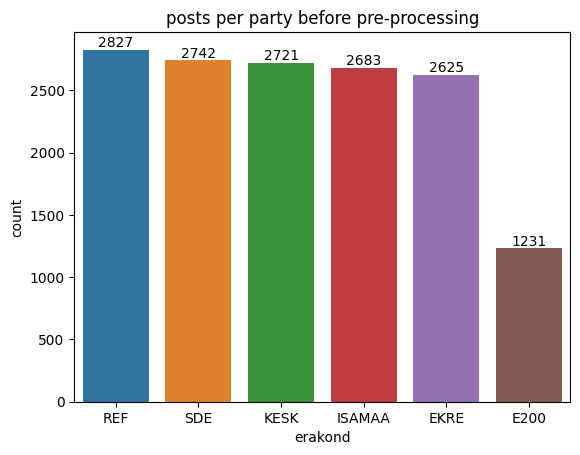

In [7]:
ax = sns.countplot(x=df["erakond"], order = df['erakond'].value_counts().index)
ax.set(title='posts per party before pre-processing')
ax.bar_label(ax.containers[0])
plt.show()